In [1]:
from model import BERT
from torch import load
from utilities import connect_rds

In [2]:
# init bert model
model = BERT().to('cuda:0')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [3]:
# load model state post training
checkpoint = load('./checkpoints/modelchkpt.pt', map_location='cpu')

In [4]:
# set model to model state 
model.load_state_dict(checkpoint['model_state_dict']) 
model.eval()


BERT(
  (encoder): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
    

### get cyberpunk comments

In [5]:
import pandas as pd

In [28]:
rds_conn = connect_rds(False)


In [82]:
fetch_cmd = """SELECT * FROM Comments 
               WHERE game like 'Cyberpunk 2077';"""

In [83]:
# read results into dataframe 
df = pd.read_sql_query(fetch_cmd, rds_conn)

In [84]:
def prnt_catch(row):
    if row['body'][:6] == 'PARENT':
        return True
    return False


def truncate(row):
    if row['body'][:6] == 'PARENT':
        return row['body'][8:520]
    return row['body'][:512]

In [85]:
df.head()

,parent_url,parent_upvotes,comment_upvotes,_date,game,body
0,https://www.reddit.com/r/cyberpunkgame/comment...,815,819,2020-12-08 05:35:45,Cyberpunk 2077,PARENT: I mean... Alanah Pearce shared one of ...
1,https://www.reddit.com/r/cyberpunkgame/comment...,187,14,2020-12-04 05:00:13,Cyberpunk 2077,So preload starts on Monday the 7th at 12 pm C...
2,https://www.reddit.com/r/cyberpunkgame/comment...,5576,28,2020-12-05 10:50:22,Cyberpunk 2077,CDPR is just the best gaming company we have. ...
3,https://www.reddit.com/r/cyberpunkgame/comment...,1151,1,2020-12-05 18:10:08,Cyberpunk 2077,I've been watching some of the leaks. Won't sa...
4,https://www.reddit.com/r/cyberpunkgame/comment...,4469,-3,2020-12-07 11:27:59,Cyberpunk 2077,"lmao that's amazing. I'm new to PC gaming, wha..."


In [86]:
df = df[['parent_upvotes', 'comment_upvotes', '_date', 'body']]
df['prnt'] = df.apply(prnt_catch, axis=1)
df['t_body'] = df.apply(truncate, axis=1)

In [87]:
df.head()

,parent_upvotes,comment_upvotes,_date,body,prnt,t_body
0,815,819,2020-12-08 05:35:45,PARENT: I mean... Alanah Pearce shared one of ...,True,I mean... Alanah Pearce shared one of em!\n\n[...
1,187,14,2020-12-04 05:00:13,So preload starts on Monday the 7th at 12 pm C...,False,So preload starts on Monday the 7th at 12 pm C...
2,5576,28,2020-12-05 10:50:22,CDPR is just the best gaming company we have. ...,False,CDPR is just the best gaming company we have. ...
3,1151,1,2020-12-05 18:10:08,I've been watching some of the leaks. Won't sa...,False,I've been watching some of the leaks. Won't sa...
4,4469,-3,2020-12-07 11:27:59,"lmao that's amazing. I'm new to PC gaming, wha...",False,"lmao that's amazing. I'm new to PC gaming, wha..."


In [88]:
from torchtext import data
from transformers import BertTokenizerFast
import torch

In [89]:
# using tokenizer from huggingface
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [90]:
import torch.nn.functional as F

In [91]:
def eval_sentiment(row):
    # read and tokenize comment 
    comment = row['t_body']
    input = tokenizer.encode(comment, return_tensors="pt")
    input = input.type(torch.cuda.LongTensor)
    
    # run tokenized comment through model 
    output = model(input, None, training=False)
    logits = output[0]

    # get more legible result from logits
    softmax_out = F.softmax(logits)
    neg = float(softmax_out[0][0])
    pos = float(softmax_out[0][1])

    return pos

In [92]:
df['pos'] = df.apply(eval_sentiment, axis=1)

In [93]:
print(df['pos'].mean())
df.head()

0.5069084622298986


,parent_upvotes,comment_upvotes,_date,body,prnt,t_body,pos
0,815,819,2020-12-08 05:35:45,PARENT: I mean... Alanah Pearce shared one of ...,True,I mean... Alanah Pearce shared one of em!\n\n[...,0.905075
1,187,14,2020-12-04 05:00:13,So preload starts on Monday the 7th at 12 pm C...,False,So preload starts on Monday the 7th at 12 pm C...,0.458928
2,5576,28,2020-12-05 10:50:22,CDPR is just the best gaming company we have. ...,False,CDPR is just the best gaming company we have. ...,0.988080
3,1151,1,2020-12-05 18:10:08,I've been watching some of the leaks. Won't sa...,False,I've been watching some of the leaks. Won't sa...,0.858353
4,4469,-3,2020-12-07 11:27:59,"lmao that's amazing. I'm new to PC gaming, wha...",False,"lmao that's amazing. I'm new to PC gaming, wha...",0.971284


In [94]:
'''df_a = df[df['pos'] >= 0.6]
df_b = df[df['pos'] <= 0.4]
df = pd.concat([df_a, df_b])'''

"df_a = df[df['pos'] >= 0.6]\ndf_b = df[df['pos'] <= 0.4]\ndf = pd.concat([df_a, df_b])"

In [95]:
def get_day(row):
    day = str(row['_date']).split(' ')[0]
    return day


df['day'] = df.apply(get_day, axis=1)
df = df.drop(columns=['_date', 'body'])

In [96]:
avgs = df.groupby(by=['day']).mean()
avgs.head(5)

,parent_upvotes,comment_upvotes,prnt,pos
day,,,,
2020-11-25,175.157692,7.965385,0.046154,0.511606
2020-11-26,25.729730,5.513514,0.162162,0.494019
2020-11-27,67.529412,7.691176,0.073529,0.645147
2020-11-28,23.767442,8.209302,0.209302,0.638515
2020-11-29,277.820652,16.494565,0.076087,0.583901


In [97]:
std = df.groupby(by=['day']).std()
std.head(5)

,parent_upvotes,comment_upvotes,prnt,pos
day,,,,
2020-11-25,164.397960,46.027719,0.210223,0.293842
2020-11-26,17.903520,7.758943,0.373684,0.383859
2020-11-27,78.102491,25.584867,0.261968,0.286274
2020-11-28,10.216320,10.611221,0.411625,0.353864
2020-11-29,323.082228,67.391767,0.265861,0.334975


In [98]:
sm = df.groupby('day').sum()
sm.head(15)

,parent_upvotes,comment_upvotes,prnt,pos
day,,,,
2020-11-25,45541,2071,12,133.017572
2020-11-26,952,204,6,18.278718
2020-11-27,9184,1046,10,87.739971
2020-11-28,1022,353,9,27.456130
2020-11-29,51119,3035,14,107.437847
2020-11-30,371554,13069,33,409.434431
2020-12-01,404623,19171,22,224.381486
2020-12-02,40184,2889,17,101.263737
2020-12-03,936298,32211,16,98.743011


In [99]:
posts_by_day = df.groupby('day')

In [100]:
days = df['day'].unique()


In [101]:
# set downvoted (negative) comments to 0
df['comment_upvotes'] = df['comment_upvotes'].clip(lower=0)

In [102]:
upvotes = {}
for day in days:
    temp = posts_by_day.get_group(day)
    upvotes[day] = temp.sum()['comment_upvotes']

upvotes

{'2020-12-08': 18145,
 '2020-12-04': 2052,
 '2020-12-05': 17140,
 '2020-12-07': 13382,
 '2020-12-09': 6908,
 '2020-12-18': 112962,
 '2020-12-19': 34063,
 '2020-11-30': 13096,
 '2020-11-28': 353,
 '2020-11-29': 3038,
 '2020-11-27': 1055,
 '2020-11-25': 2085,
 '2020-11-26': 208,
 '2020-12-21': 1057,
 '2020-12-14': 12555,
 '2020-12-20': 12,
 '2020-12-12': 15848,
 '2020-12-13': 298,
 '2020-12-15': 13634,
 '2020-12-11': 12124,
 '2020-12-03': 32214,
 '2020-12-06': 15245,
 '2020-12-10': 768,
 '2020-12-17': 6555,
 '2020-12-16': 17519,
 '2020-12-02': 2902,
 '2020-12-01': 19173,
 '2020-12-22': 95,
 '2020-12-23': 35,
 '2020-12-24': 54}

In [103]:
def weight_comments(row):
    #if row['prnt'] == TRUE:
    day = row['day']
    total_upvotes = upvotes[day]
    return row['comment_upvotes']/total_upvotes


df['share_of_upvotes'] = df.apply(weight_comments, axis=1)

df.head()

,parent_upvotes,comment_upvotes,prnt,t_body,pos,day,share_of_upvotes
0,815,819,True,I mean... Alanah Pearce shared one of em!\n\n[...,0.905075,2020-12-08,0.045136
1,187,14,False,So preload starts on Monday the 7th at 12 pm C...,0.458928,2020-12-04,0.006823
2,5576,28,False,CDPR is just the best gaming company we have. ...,0.988080,2020-12-05,0.001634
3,1151,1,False,I've been watching some of the leaks. Won't sa...,0.858353,2020-12-05,0.000058
4,4469,0,False,"lmao that's amazing. I'm new to PC gaming, wha...",0.971284,2020-12-07,0.000000


In [104]:
df['???'] = df['pos'] * 100 * df['share_of_upvotes']
df.head()

,parent_upvotes,comment_upvotes,prnt,t_body,pos,day,share_of_upvotes,???
0,815,819,True,I mean... Alanah Pearce shared one of em!\n\n[...,0.905075,2020-12-08,0.045136,4.085184
1,187,14,False,So preload starts on Monday the 7th at 12 pm C...,0.458928,2020-12-04,0.006823,0.313109
2,5576,28,False,CDPR is just the best gaming company we have. ...,0.988080,2020-12-05,0.001634,0.161413
3,1151,1,False,I've been watching some of the leaks. Won't sa...,0.858353,2020-12-05,0.000058,0.005008
4,4469,0,False,"lmao that's amazing. I'm new to PC gaming, wha...",0.971284,2020-12-07,0.000000,0.000000


[Text(0, 0, '2020-11-25'),
 Text(1, 0, '2020-11-26'),
 Text(2, 0, '2020-11-27'),
 Text(3, 0, '2020-11-28'),
 Text(4, 0, '2020-11-29'),
 Text(5, 0, '2020-11-30'),
 Text(6, 0, '2020-12-01'),
 Text(7, 0, '2020-12-02'),
 Text(8, 0, '2020-12-03'),
 Text(9, 0, '2020-12-04'),
 Text(10, 0, '2020-12-05'),
 Text(11, 0, '2020-12-06'),
 Text(12, 0, '2020-12-07'),
 Text(13, 0, '2020-12-08'),
 Text(14, 0, '2020-12-09'),
 Text(15, 0, '2020-12-10'),
 Text(16, 0, '2020-12-11'),
 Text(17, 0, '2020-12-12'),
 Text(18, 0, '2020-12-13'),
 Text(19, 0, '2020-12-14'),
 Text(20, 0, '2020-12-15'),
 Text(21, 0, '2020-12-16'),
 Text(22, 0, '2020-12-17'),
 Text(23, 0, '2020-12-18'),
 Text(24, 0, '2020-12-19'),
 Text(25, 0, '2020-12-20'),
 Text(26, 0, '2020-12-21'),
 Text(27, 0, '2020-12-22'),
 Text(28, 0, '2020-12-23'),
 Text(29, 0, '2020-12-24')]

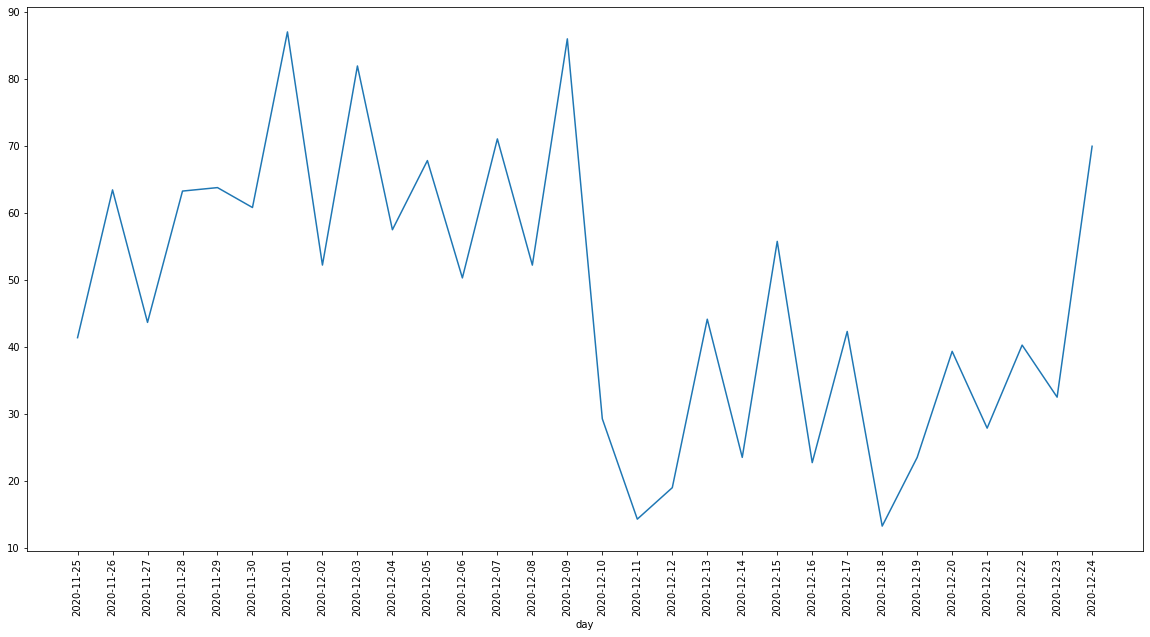

In [118]:
ax = df.groupby('day').sum()['???'].plot(figsize=(20,10))
ax.set_xticks(range(len(days)))
ax.set_xticklabels(sorted(days), rotation=90)

[Text(0, 0, '2020-11-25'),
 Text(1, 0, '2020-11-26'),
 Text(2, 0, '2020-11-27'),
 Text(3, 0, '2020-11-28'),
 Text(4, 0, '2020-11-29'),
 Text(5, 0, '2020-11-30'),
 Text(6, 0, '2020-12-01'),
 Text(7, 0, '2020-12-02'),
 Text(8, 0, '2020-12-03'),
 Text(9, 0, '2020-12-04'),
 Text(10, 0, '2020-12-05'),
 Text(11, 0, '2020-12-06'),
 Text(12, 0, '2020-12-07'),
 Text(13, 0, '2020-12-08'),
 Text(14, 0, '2020-12-09'),
 Text(15, 0, '2020-12-10'),
 Text(16, 0, '2020-12-11'),
 Text(17, 0, '2020-12-12'),
 Text(18, 0, '2020-12-13'),
 Text(19, 0, '2020-12-14'),
 Text(20, 0, '2020-12-15'),
 Text(21, 0, '2020-12-16'),
 Text(22, 0, '2020-12-17'),
 Text(23, 0, '2020-12-18'),
 Text(24, 0, '2020-12-19'),
 Text(25, 0, '2020-12-20'),
 Text(26, 0, '2020-12-21'),
 Text(27, 0, '2020-12-22'),
 Text(28, 0, '2020-12-23'),
 Text(29, 0, '2020-12-24')]

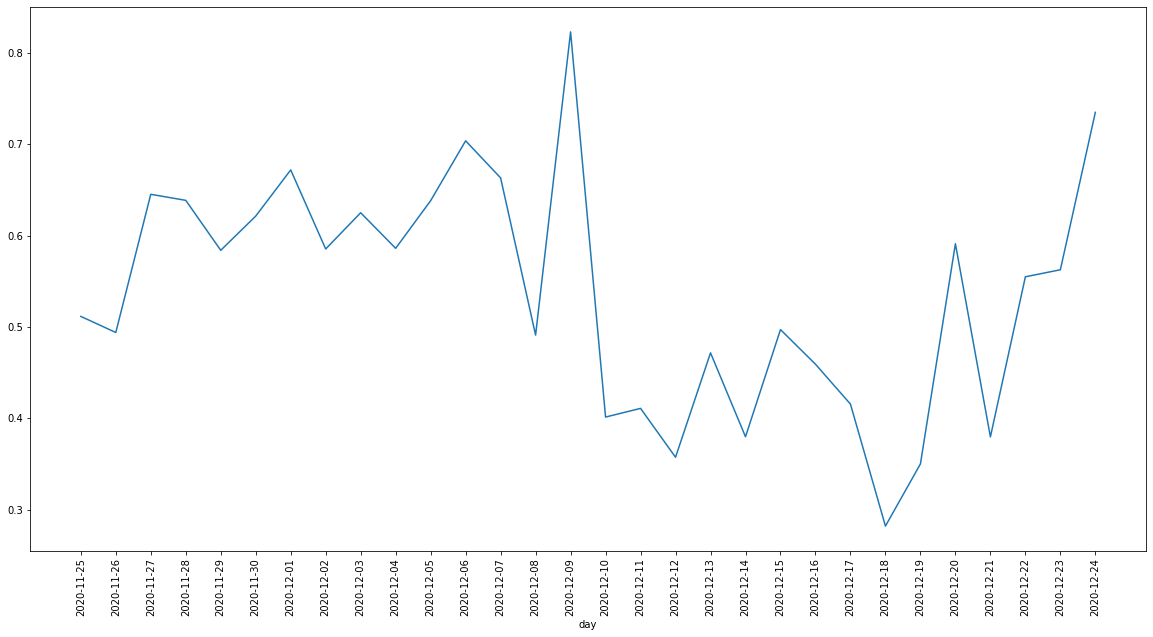

In [117]:
ax = df.groupby('day').mean()['pos'].plot(figsize=(20,10))
ax.set_xticks(range(len(days)))
ax.set_xticklabels(sorted(days), rotation=90)